<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/ready/Flower5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

!pip install torchsummary

import torch

In [6]:
# Load train class
!wget -c https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py

import Train

--2018-12-27 17:27:53--  https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15107 (15K) [text/plain]
Saving to: ‘Train.py’

Train.py            100%[===================>]  14.75K  --.-KB/s    in 0.006s  

2018-12-27 17:27:53 (2.22 MB/s) - ‘Train.py’ saved [15107/15107]



# Load previous model

In [0]:
from torchvision import models
# load a pretrained model
model = models.densenet161(pretrained = True)
print(model)

In [0]:
# laod model
model, optimizer, scheduler = Train.load_checkpoint("model27_11.pt", model, optimizer, scheduler)

# Build

In [0]:
# if model is not save then run this cell

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer
        self.fc1 = nn.Linear(2208, 1780)
        self.fc2 = nn.Linear(1780, 1560)
        self.fc3 = nn.Linear(1560, 1560)
        self.fc4 = nn.Linear(1560, 102)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layer
        # flatten image input
        x = x.view(x.shape[0], -1)
        
        # add dropout layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # add 2nd hidden layer, with relu activation function
        x = self.fc4(x)
        return x

In [0]:
# if model is not save then run this cell
# change classifier
model.classifier = Net()
model.classifier

In [0]:
# if model is not save then run this cell

import torch
from torch import optim
from torch.optim import lr_scheduler
# set cretrion and optimizer
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#move tensor to default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare Data

In [9]:
# Load data
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

!unzip -qq flower_data.zip

print("Data loaded")

Data loaded


In [10]:
import Train

# create train and test loader
data_dir = 'flower_data'

from torchvision import datasets, transforms

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# ceate data loader
train_loader, valid_loader, test_loader = Train.prepare_loader(data_dir,transform_train,transform_valid,test_transforms)

Train size:6552
Valid size:6552
Test size:818


# Train Model

In [7]:
# Freeze the parameter
model = Train.freeze_parameters(model)
#for _, param in model.named_parameters():
#  param.requires_grad = False
print("Parameter Freezed")

Parameter Freezed


In [0]:
# Unfreeze the parameter
model = Train.unfreeze(model)
#for _, param in model.named_parameters():
#  param.requires_grad = True

print("Parameter unfreezed")

Parameter unfreezed


In [1]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

Uninstalling Pillow-4.0.0:
  Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 1.7MB/s 


In [0]:
# Train model
epochs = 7
model, train_loss,valid_loss = Train.train_model(
    model,train_loader,valid_loader, epochs, optimizer,scheduler, criterion)

# Load model

In [0]:
# Load best model
name = "model.pt"
model.load_state_dict(torch.load(name))

In [0]:
#save model for further use
torch.save(model.state_dict(),"model74freeze.pt")

# Testing

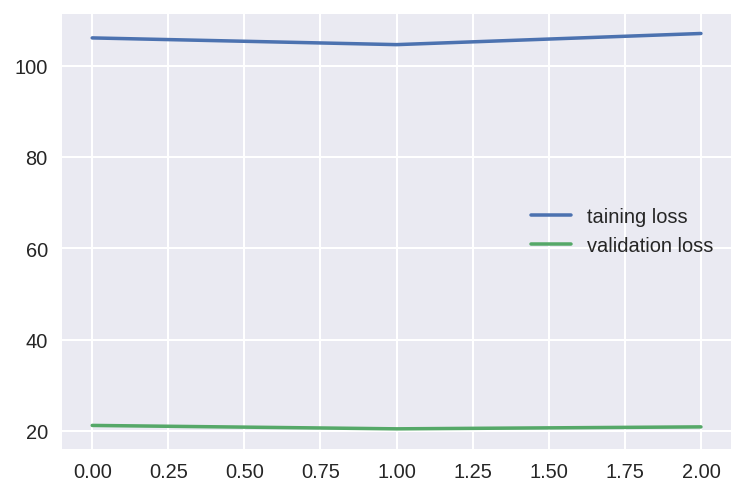

In [0]:
#Check for overfitting

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_loss, label = "taining loss")
plt.plot(valid_loss, label = "validation loss")
plt.legend(frameon = False)

In [9]:
# Test accuracy top 10 classs
Train.calculate_top_accuracy(model, test_loader, criterion)

Test Loss: 0.051838

Test Accuracy of     0:  0% ( 0/ 4)
Test Accuracy of     1: 100% ( 2/ 2)
Test Accuracy of     2: 33% ( 2/ 6)
Test Accuracy of     3: 100% ( 4/ 4)
Test Accuracy of     4: 100% ( 5/ 5)
Test Accuracy of     5: 33% ( 2/ 6)
Test Accuracy of     6: 100% ( 2/ 2)
Test Accuracy of    22: N/A (no training examples)
Test Accuracy of     8:  0% ( 0/ 1)
Test Accuracy of     9: 50% ( 1/ 2)

Test Accuracy (Overall): 73% (303/410)


In [0]:
# Test total accuracy
Train.calc_accuracy(model,testset_path="flower_data/valid",batch_size=batch_size)

In [0]:
# Test with google data set
Train.calc_accuracy(model,use_google_testset=True,batch_size=batch_size)

# Save checkpoint

In [0]:
#save model
name = "model27_11.pt"
Train.save_check_point(model, optimizer, scheduler, train_loader, name, epoch, save_cpu=False)

In [0]:
#load model again
name = "model27_11.pt"
model, optimizer, scheduler = Train.load_checkpoint(name, model, optimizer, scheduler)

# Image Preprocessing

In [10]:
#Time for visalize
cat_to_name = Train.get_cat_name()
class_to_idx = train_loader.dataset.class_to_idx
idx_to_name = {idx: cat_to_name[category] for category, idx in train_loader.dataset.class_to_idx.items()}
list(idx_to_name.items())[:6]
list(cat_to_name.keys())[:6]

['21', '3', '45', '1', '34', '27']

In [0]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a PyTorch tensor
    '''
    
    image = Image.open(image_path)
    
    # Resize
    img = image.resize((256, 256))
    
    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    img = img.crop((left, top, right, bottom))
    
    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256
    
    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)
    
    return img_tensor

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image); plt.axis('off')
    
    return ax, image

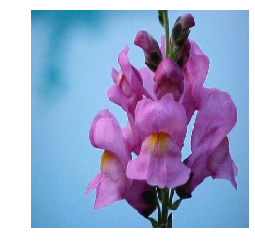

In [16]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
img = process_image('flower_data/valid/11/image_03125.jpg')
ax, image = imshow(img)

# Class Prediction

In [0]:
def random_image_path():
    """Generate a random image path from validation set"""
    cat = np.random.choice(os.listdir(f'flower_data/valid/'))
    image_filename = np.random.choice(os.listdir(f'flower_data/valid/{cat}/'))
    ex_path = f'flower_data/valid/{cat}/' + image_filename
    print(f"Path:{ex_path}")
    return ex_path

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    real_class = model.cat_to_name[image_path.split('/')[2]]
    img_tensor = process_image(image_path)
    
    if torch.cuda.is_available():
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Output is not a probability or a log probability
        out = model(img_tensor)
        
        # Apply softmax across classes
        ps = torch.softmax(out, dim = 1)
        
        topk, topclass = ps.topk(topk, dim = 1)
        top_classes = [model.idx_to_name[class_] for class_ in topclass.cpu().numpy()[0]]
        top_ps = topk.cpu().numpy()[0]
        return top_ps, top_classes, real_class, img_tensor.cpu().squeeze()

In [0]:
ex_path = random_image_path()
ps, classes, y_obs, img = predict(ex_path, model)

In [0]:
ax, img = imshow(img);
ax.set_title(y_obs);
ps, classes

# Sanity Checking



In [0]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""
    # Get predictions
    real_cat = image_path.split('/')[2]
    n_train_images = len(os.listdir(f'flower_data/train/{real_cat}'))
    
    ps, classes, y_obs, img = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index = classes)
    
    plt.figure(figsize = (6, 5))
    ax = plt.subplot(1, 1, 1)
    ax, img = imshow(img, ax = ax);
    ax.set_title(y_obs, size = 20);
    plt.show();
    
    result.sort_values('p')['p'].plot.barh(color = 'blue', edgecolor = 'k');
    plt.xlabel('Predicted Probability'); plt.ylabel('Classes');
    plt.show();
    
    print(f'{n_train_images} training images for {y_obs}.')

In [0]:
import pandas as pd
ex_path = random_image_path()
display_prediction(ex_path, model, 5)

# Save on Google Drive
Save to the google drive for latter use

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
model_save_name = 'flower4_27_1a_93.pt'
path = F"/content/gdrive/My Drive/model/{model_save_name}" 
torch.save(model.state_dict(), path)

In [0]:
#Save checkpoint
name = "model27_11.pt"
Train.save_check_point(model, optimizer, scheduler, train_loader, name, epoch, save_cpu=True)